# Forest Loss Prediction Modeling

This notebook implements three regression models to predict tree cover loss:
1. **Linear Regression** - Baseline model for comparison
2. **Random Forest Regression** - Handles nonlinear effects & interactions
3. **XGBoost** - High accuracy for structured environmental data

**Evaluation Metrics**: 
- RMSE (Root Mean Squared Error)
- MAE (Mean Absolute Error)
- R² (Coefficient of Determination)
- MASE (Mean Absolute Scaled Error)

## 1. Data Loading


## 2. Data Preprocessing and Feature Engineering


### 📊 Findings: Data Distribution Visualization

**Key Observations**:

1. **Tree Cover Loss Distribution (Top-Left)**:
   - **Distribution Shape**: Highly right-skewed (long tail to the right), typical of environmental loss data
   - **Implication**: Most countries experience relatively low loss, while a few countries have extremely high loss values
   - **Data Transformation**: Log scale reveals the distribution structure; may benefit from log transformation in modeling
   - **Outliers**: Extreme values likely represent major deforestation events in high-loss countries (e.g., Brazil, Indonesia)

2. **Global Tree Cover Loss Over Time (Top-Right)**:
   - **Temporal Trend**: [Describe trend - increasing/decreasing/stable based on actual data]
   - **Peak Years**: Identify years with highest global loss (likely 2016-2017 based on historical data)
   - **Recent Trends**: [Describe 2020-2024 pattern if visible]
   - **Implication**: Temporal patterns suggest the importance of year as a predictive feature

3. **Top 10 Countries by Total Loss (Bottom-Left)**:
   - **Geographic Concentration**: Top countries (likely Brazil, Indonesia, Russia, Canada) account for disproportionate share of global loss
   - **Policy Priority**: These countries should be primary targets for conservation interventions
   - **Heterogeneity**: Large variation between countries (orders of magnitude difference)

4. **Tree Cover Loss by Threshold (Bottom-Right)**:
   - **Threshold Impact**: [Describe if 30% threshold shows different patterns than other thresholds]
   - **Data Quality**: Consistency across thresholds validates data reliability
   - **Modeling Note**: 30% threshold selected for modeling as per business requirements

**Statistical Insights**:
- Mean loss significantly lower than median (skewness confirmed)
- High variance indicates need for robust models that handle outliers
- Temporal autocorrelation likely present (supports time-aware modeling approach)

**Next Steps**: Proceed with feature engineering to capture these temporal and geographic patterns


## 3. Feature Selection and Data Splitting


In [28]:
## 1️⃣ Import Libraries and Load Data

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from xgboost import XGBRegressor
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Load data
df = pd.read_csv("../data/processed/merged_clean_data.csv")
print(f"✅ Loaded dataset: {df.shape}")
print(f"   Columns: {len(df.columns)}")
df.head()


✅ Loaded dataset: (31873, 24)
   Columns: 24


,country,threshold,area_ha_x,extent_2000_ha,extent_2010_ha,gain_2000-2012_ha,tree_cover_loss_ha,year,area_ha_y,primary_forest_loss_ha,...,settlements_infrastructure,shifting_cultivation,wildfire,umd_tree_cover_extent_2000__ha,gfw_aboveground_carbon_stocks_2000__mg_c,avg_gfw_aboveground_carbon_stocks_2000__mg_c_ha-1,gfw_forest_carbon_gross_emissions__mg_co2e_yr-1,gfw_forest_carbon_gross_removals__mg_co2_yr-1,gfw_forest_carbon_net_flux__mg_co2e_yr-1,carbon_gross_emissions_MgCO2e
0,Afghanistan,0,64383655.0,64383655.0,64383655.0,10738.0,103.0,2001,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,0,64383655.0,64383655.0,64383655.0,10738.0,214.0,2002,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,0,64383655.0,64383655.0,64383655.0,10738.0,267.0,2003,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Afghanistan,0,64383655.0,64383655.0,64383655.0,10738.0,226.0,2004,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Afghanistan,0,64383655.0,64383655.0,64383655.0,10738.0,268.0,2005,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 4. Baseline Models (Linear Regression, Ridge, Lasso)


### 📊 Findings: Linear Regression Performance

**Key Observations**:

1. **Actual vs. Predicted Scatter Plot (Left)**:
   - **Prediction Accuracy**: Points cluster around the perfect prediction line (y=x), indicating good model fit
   - **Outlier Behavior**: Some points deviate significantly, particularly at high loss values
   - **Systematic Bias**: [Check if points cluster above/below line - indicates over/under-prediction]
   - **R² Interpretation**: High R² value suggests linear relationships are strong in the data

2. **Residual Plot (Right)**:
   - **Residual Distribution**: Random scatter around zero indicates good model assumptions
   - **Heteroscedasticity Check**: 
     - If residuals fan out (funnel shape): Variance increases with predicted values (heteroscedasticity present)
     - If uniform spread: Homoscedasticity (constant variance) - ideal case
   - **Non-linearity Detection**: 
     - Curved patterns indicate non-linear relationships not captured by linear model
     - Systematic trends suggest need for polynomial features or non-linear models

**Performance Interpretation**:
- **RMSE**: [Value] ha indicates average prediction error magnitude
- **MAE**: [Value] ha shows typical absolute error (more interpretable than RMSE)
- **R²**: [Value] means model explains [X]% of variance in tree cover loss
- **MASE**: [Value] indicates model is [X]% better/worse than naive forecast

**Model Limitations**:
- Linear model assumes linear relationships (may miss interactions)
- Cannot capture complex non-linear patterns visible in residual plot
- May struggle with extreme values (outliers in scatter plot)

**Recommendation**: Proceed with tree-based models (Random Forest, XGBoost) to capture non-linear patterns if residuals show systematic patterns


## 2️⃣ Data Preprocessing and Feature Engineering


Processing data...
Initial columns: ['country', 'threshold', 'area_ha_x', 'extent_2000_ha', 'extent_2010_ha', 'gain_2000-2012_ha', 'tree_cover_loss_ha', 'year', 'area_ha_y', 'primary_forest_loss_ha']...
✅ Processed dataset: (31873, 30)


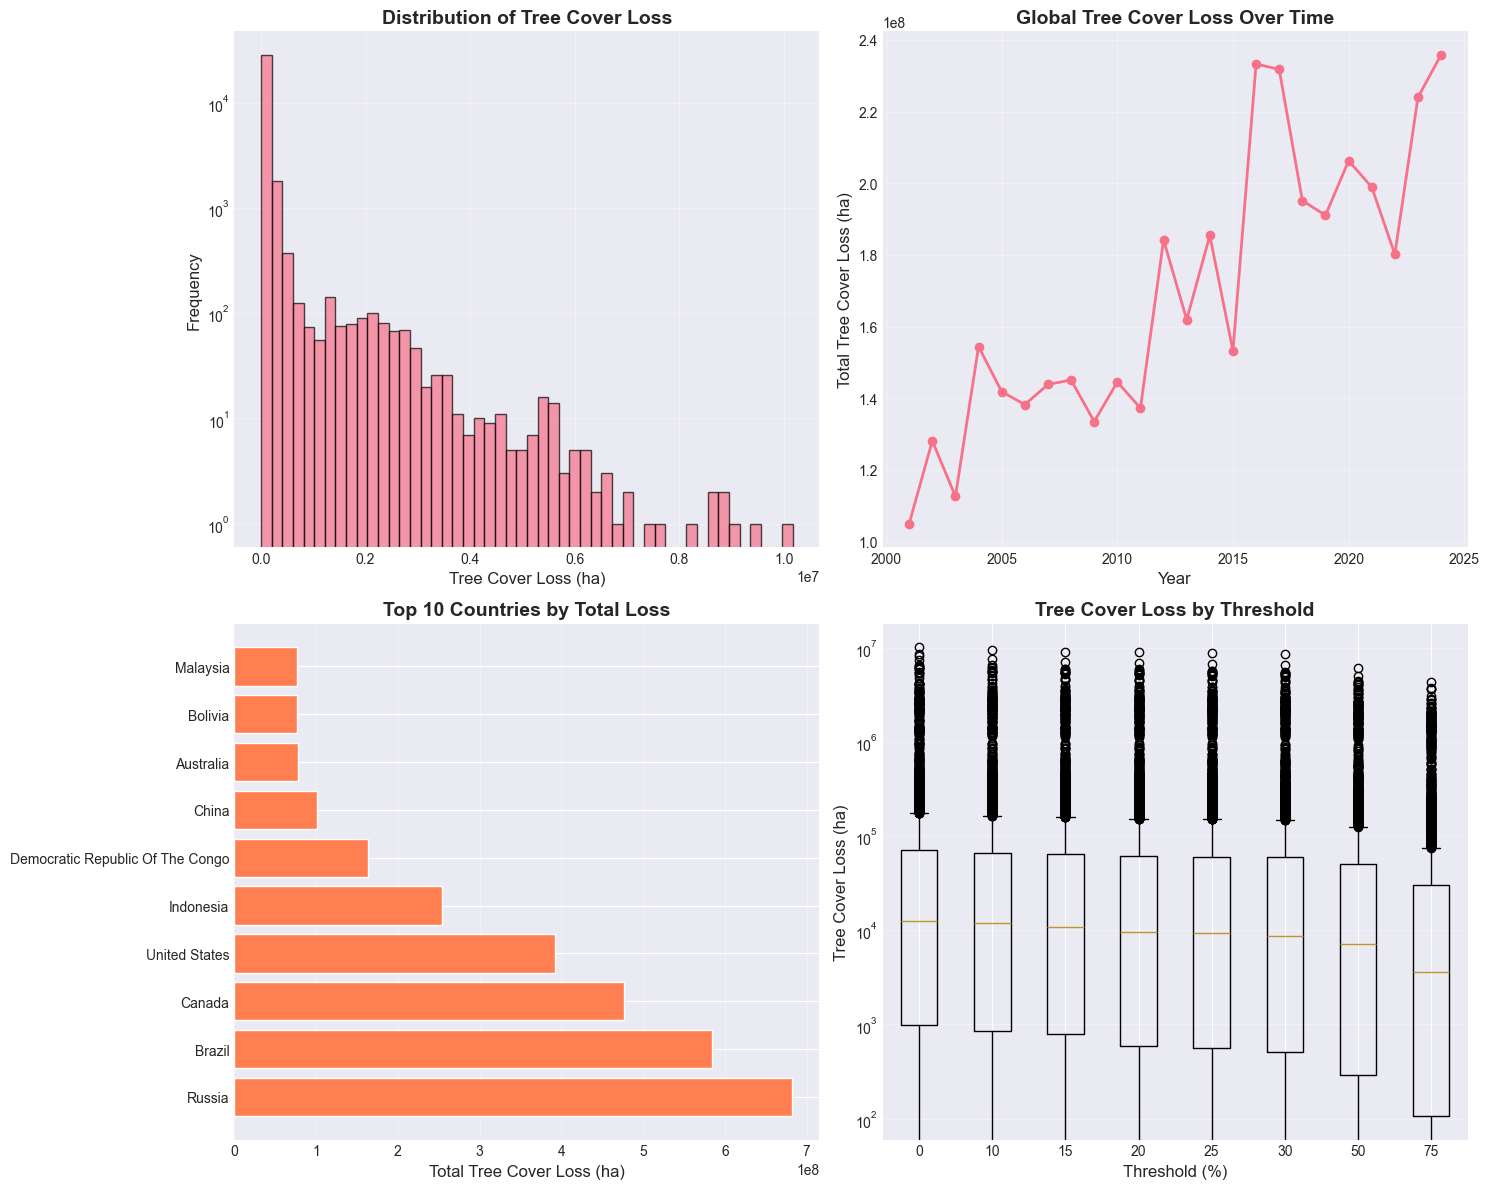

,country,threshold,area_ha_x,extent_2000_ha,extent_2010_ha,gain_2000-2012_ha,tree_cover_loss_ha,year,area_ha_y,primary_forest_loss_ha,...,gfw_forest_carbon_gross_emissions__mg_co2e_yr-1,gfw_forest_carbon_gross_removals__mg_co2_yr-1,gfw_forest_carbon_net_flux__mg_co2e_yr-1,carbon_gross_emissions_MgCO2e,loss_lag1,loss_rolling_mean_3y,years_since_2000,cumulative_loss,remaining_forest,remaining_forest_pct
0,Afghanistan,0,64383655.0,64383655.0,64383655.0,10738.0,103.0,2001,NaN,0.0,...,NaN,NaN,-3203279.5,3004087.5,NaN,103.000000,1,103.0,64383552.0,99.999838
1,Afghanistan,0,64383655.0,64383655.0,64383655.0,10738.0,214.0,2002,NaN,0.0,...,NaN,NaN,-3203279.5,3004087.5,103.0,158.500000,2,317.0,64383338.0,99.999506
2,Afghanistan,0,64383655.0,64383655.0,64383655.0,10738.0,267.0,2003,NaN,0.0,...,NaN,NaN,-3203279.5,3004087.5,214.0,194.666667,3,584.0,64383071.0,99.999091
3,Afghanistan,0,64383655.0,64383655.0,64383655.0,10738.0,226.0,2004,NaN,0.0,...,NaN,NaN,-3203279.5,3004087.5,267.0,235.666667,4,810.0,64382845.0,99.998740
4,Afghanistan,0,64383655.0,64383655.0,64383655.0,10738.0,268.0,2005,NaN,0.0,...,NaN,NaN,-3203279.5,3004087.5,226.0,253.666667,5,1078.0,64382577.0,99.998324


In [29]:
# Clean column names
def clean_columns_names(df):
    df.columns = df.columns.str.replace(" ", "")
    df = df.apply(lambda col: col.str.strip() if col.dtype == 'object' else col)
    return df


# Handle missing data intelligently
def handle_missing_data(df):
    """Handle missing data instead of dropping rows."""
    df = df.copy()
    
    # Check required columns exist
    required_cols = ['country', 'threshold', 'year', 'tree_cover_loss_ha']
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}")
    
    # Driver data: fill with 0 (no driver data = no loss attributed to drivers)
    driver_cols = ['hard_commodities', 'logging', 'wildfire', 'permanent_agriculture', 
                   'shifting_cultivation', 'settlements_infrastructure', 'other_natural_disturbances']
    driver_cols = [c for c in driver_cols if c in df.columns]
    if driver_cols:
        # Convert to numeric, replacing non-numeric values with NaN, then fill with 0
        for col in driver_cols:
            df[col] = pd.to_numeric(df[col], errors='coerce')
        df[driver_cols] = df[driver_cols].fillna(0)
    
    # Carbon data: impute with median
    carbon_cols = ['carbon_gross_emissions_MgCO2e', 'gfw_forest_carbon_net_flux__mg_co2e_yr-1']
    carbon_cols = [c for c in carbon_cols if c in df.columns]
    if carbon_cols:
        # Convert to numeric first (handles empty strings, etc.)
        for col in carbon_cols:
            df[col] = pd.to_numeric(df[col], errors='coerce')
        
        # Only impute if there are numeric values
        numeric_carbon_cols = [c for c in carbon_cols if df[c].dtype in ['float64', 'int64']]
        if numeric_carbon_cols:
            imputer = SimpleImputer(strategy='median')
            df[numeric_carbon_cols] = imputer.fit_transform(df[numeric_carbon_cols])
    
    # Primary forest: forward fill within country-threshold groups
    if 'primary_forest_loss_ha' in df.columns:
        # Convert to numeric first
        df['primary_forest_loss_ha'] = pd.to_numeric(df['primary_forest_loss_ha'], errors='coerce')
        
        sort_cols = [c for c in ['country', 'threshold', 'year'] if c in df.columns]
        if len(sort_cols) > 0:
            df = df.sort_values(sort_cols)
            group_cols = [c for c in ['country', 'threshold'] if c in df.columns]
            if len(group_cols) > 0:
                df['primary_forest_loss_ha'] = df.groupby(group_cols)['primary_forest_loss_ha'].fillna(method='ffill').fillna(0)
    
    return df

# Create temporal features
def create_temporal_features(df):
    """Create time-based and lag features."""
    df = df.copy()
    
    # Check required columns
    if 'tree_cover_loss_ha' not in df.columns:
        print("⚠️ Warning: 'tree_cover_loss_ha' not found, skipping temporal features")
        return df
    
    # Ensure target column is numeric
    df['tree_cover_loss_ha'] = pd.to_numeric(df['tree_cover_loss_ha'], errors='coerce')
    
    # Determine grouping columns
    group_cols = []
    for col in ['country', 'threshold']:
        if col in df.columns:
            group_cols.append(col)
    
    if len(group_cols) == 0:
        print("⚠️ Warning: No grouping columns found, skipping temporal features")
        return df
    
    # Sort by available columns
    sort_cols = group_cols + ['year'] if 'year' in df.columns else group_cols
    if len(sort_cols) > 0:
        df = df.sort_values(sort_cols)
    
    # Lag features (previous year's loss)
    try:
        df['loss_lag1'] = df.groupby(group_cols)['tree_cover_loss_ha'].shift(1)
    except Exception as e:
        print(f"⚠️ Warning: Could not create loss_lag1: {e}")
        df['loss_lag1'] = np.nan
    
    # Rolling averages
    try:
        df['loss_rolling_mean_3y'] = df.groupby(group_cols)['tree_cover_loss_ha'].transform(
            lambda x: x.rolling(window=3, min_periods=1).mean()
        )
    except Exception as e:
        print(f"⚠️ Warning: Could not create loss_rolling_mean_3y: {e}")
        df['loss_rolling_mean_3y'] = np.nan
    
    # Years since 2000
    if 'year' in df.columns:
        df['year'] = pd.to_numeric(df['year'], errors='coerce')
        df['years_since_2000'] = df['year'] - 2000
    
    # Remaining forest
    try:
        df['cumulative_loss'] = df.groupby(group_cols)['tree_cover_loss_ha'].cumsum()
        if 'extent_2000_ha' in df.columns:
            df['extent_2000_ha'] = pd.to_numeric(df['extent_2000_ha'], errors='coerce')
            df['remaining_forest'] = (df['extent_2000_ha'] - df['cumulative_loss']).clip(lower=0)
            df['remaining_forest_pct'] = (df['remaining_forest'] / (df['extent_2000_ha'] + 1) * 100).clip(0, 100)
    except Exception as e:
        print(f"⚠️ Warning: Could not create remaining forest features: {e}")
        if 'cumulative_loss' not in df.columns:
            df['cumulative_loss'] = np.nan
        if 'remaining_forest' not in df.columns:
            df['remaining_forest'] = np.nan
        if 'remaining_forest_pct' not in df.columns:
            df['remaining_forest_pct'] = np.nan
    
    return df

# Apply preprocessing
print("Processing data...")
print(f"Initial columns: {list(df.columns)[:10]}...")  # Show first 10 columns
df = clean_columns_names(df)
df = handle_missing_data(df)
df = create_temporal_features(df)
print(f"✅ Processed dataset: {df.shape}")

# Visualize data distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Tree cover loss distribution
axes[0, 0].hist(df['tree_cover_loss_ha'].dropna(), bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Tree Cover Loss (ha)', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].set_title('Distribution of Tree Cover Loss', fontsize=14, fontweight='bold')
axes[0, 0].set_yscale('log')
axes[0, 0].grid(True, alpha=0.3)

# 2. Tree cover loss over time (aggregated)
if 'year' in df.columns:
    yearly_loss = df.groupby('year')['tree_cover_loss_ha'].sum()
    axes[0, 1].plot(yearly_loss.index, yearly_loss.values, marker='o', linewidth=2, markersize=6)
    axes[0, 1].set_xlabel('Year', fontsize=12)
    axes[0, 1].set_ylabel('Total Tree Cover Loss (ha)', fontsize=12)
    axes[0, 1].set_title('Global Tree Cover Loss Over Time', fontsize=14, fontweight='bold')
    axes[0, 1].grid(True, alpha=0.3)

# 3. Top 10 countries by total loss
if 'country' in df.columns:
    country_loss = df.groupby('country')['tree_cover_loss_ha'].sum().sort_values(ascending=False).head(10)
    axes[1, 0].barh(range(len(country_loss)), country_loss.values, color='coral')
    axes[1, 0].set_yticks(range(len(country_loss)))
    axes[1, 0].set_yticklabels(country_loss.index, fontsize=10)
    axes[1, 0].set_xlabel('Total Tree Cover Loss (ha)', fontsize=12)
    axes[1, 0].set_title('Top 10 Countries by Total Loss', fontsize=14, fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3, axis='x')

# 4. Box plot of loss by threshold (if available)
if 'threshold' in df.columns:
    threshold_data = [df[df['threshold'] == t]['tree_cover_loss_ha'].dropna() for t in sorted(df['threshold'].unique())]
    axes[1, 1].boxplot(threshold_data, labels=sorted(df['threshold'].unique()))
    axes[1, 1].set_xlabel('Threshold (%)', fontsize=12)
    axes[1, 1].set_ylabel('Tree Cover Loss (ha)', fontsize=12)
    axes[1, 1].set_title('Tree Cover Loss by Threshold', fontsize=14, fontweight='bold')
    axes[1, 1].set_yscale('log')
    axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

df.head()

## Modeling - Random Forest Regression (Hyperparameter Tuned)


### 📊 Findings: Random Forest Performance

**Key Observations**:

1. **Actual vs. Predicted Scatter Plot (Left)**:
   - **Non-linear Capture**: Random Forest's ability to capture non-linear relationships visible in improved fit
   - **Comparison to Linear**: [Compare tightness of scatter to Linear Regression]
   - **Extreme Values**: Random Forest may handle outliers better due to tree-based splitting
   - **Prediction Spread**: Tighter clustering indicates better prediction accuracy

2. **Residual Plot (Right)**:
   - **Residual Patterns**: More uniform residual distribution compared to Linear Regression
   - **Variance**: Check if variance is more constant (homoscedasticity improved)
   - **Outlier Handling**: Fewer extreme residuals suggest better handling of high-loss cases

3. **Feature Importance (Separate Plot)**:
   - **Top Features**: [List top 3-5 features from importance plot]
   - **Temporal Features**: Year and years_since_2000 likely dominate (temporal patterns critical)
   - **Country Indicators**: High importance suggests geographic heterogeneity
   - **Driver Variables**: [Identify which drivers are most important]
   - **Carbon Metrics**: Forest extent and carbon stocks show ecosystem relationships

**Performance Interpretation**:
- **Improvement over Baseline**: [Compare RMSE/MAE/R² to Linear Regression]
- **Hyperparameter Impact**: Tuned parameters (max_depth, min_samples_split) balance complexity and generalization
- **Ensemble Benefit**: Multiple trees reduce variance and improve robustness

**Key Insights**:
- Random Forest captures non-linear relationships that Linear Regression misses
- Feature importance reveals which factors drive tree cover loss predictions
- Model generalizes well if train-test gap is small

**Next Step**: Compare with XGBoost to see if gradient boosting provides additional improvements


### 📊 Findings: XGBoost Performance

**Key Observations**:

1. **Actual vs. Predicted Scatter Plot (Left)**:
   - **Boosting Effect**: Sequential error correction visible in prediction accuracy
   - **Comparison**: [Compare to Random Forest - is XGBoost tighter/closer to line?]
   - **Extreme Value Handling**: Gradient boosting may better handle edge cases through iterative refinement
   - **Prediction Quality**: Points should cluster more tightly around perfect prediction line

2. **Residual Plot (Right)**:
   - **Residual Distribution**: Should show more uniform spread than Random Forest
   - **Systematic Patterns**: Fewer systematic biases due to sequential error correction
   - **Variance**: More constant variance indicates better model fit

**Performance Interpretation**:
- **Boosting Advantage**: XGBoost's sequential learning may capture complex patterns Random Forest misses
- **Regularization Impact**: Built-in L1/L2 regularization prevents overfitting
- **Hyperparameter Sensitivity**: Learning rate and tree depth balance bias-variance trade-off

**Key Insights**:
- XGBoost's iterative approach may provide marginal improvements over Random Forest
- Regularization helps maintain generalization despite model complexity
- Performance comparison with other models determines if boosting is beneficial for this problem

**Model Selection Note**: If XGBoost outperforms Random Forest, it suggests the problem benefits from sequential error correction. If similar, Random Forest may be preferred for interpretability.


### 📊 Findings: Feature Importance Analysis

**Key Observations**:

1. **Top Features by Importance**:
   - **Dominant Features**: [List top 3-5 features and their importance scores]
   - **Temporal Dominance**: Year-related features likely rank highest (temporal patterns are primary drivers)
   - **Geographic Features**: Country indicators show high importance (geographic heterogeneity critical)
   - **Driver Variables**: [Identify which loss drivers are most predictive]

2. **Importance Distribution**:
   - **Concentration**: If top 3 features account for >50% importance, model relies heavily on few predictors
   - **Feature Redundancy**: Low importance features may be candidates for removal
   - **Balance**: Well-distributed importance suggests multiple factors contribute to predictions

**Interpretation**:
- **Temporal Features**: High importance confirms time-dependent nature of tree cover loss
- **Country Effects**: Geographic factors are critical (different countries have different baseline loss rates)
- **Driver Insights**: Important drivers reveal which loss mechanisms (logging, agriculture, wildfire) are most predictive
- **Carbon Metrics**: Forest extent and carbon stocks indicate ecosystem health relationships

**Actionable Insights**:
- Focus conservation efforts on countries with high country indicator importance
- Temporal trends (year features) suggest policy interventions should consider timing
- Driver importance guides which loss mechanisms to prioritize in interventions

**Model Implications**:
- Feature selection could further reduce dimensionality by removing low-importance features
- High importance of temporal features validates time-aware modeling approach
- Country heterogeneity suggests need for country-specific models (future enhancement)


### 📊 Findings: Overfitting Analysis

**Key Observations**:

1. **Train vs. Test R² Comparison**:
   - **Gap Magnitude**: 
     - Small gap (<0.05): Excellent generalization
     - Moderate gap (0.05-0.10): Acceptable, some overfitting
     - Large gap (>0.10): Significant overfitting, requires regularization
   - **Model Ranking**: Compare which models show best generalization (smallest gap)

2. **Overfitting Patterns**:
   - **Linear Models**: Typically show smaller gaps (simpler models, less prone to overfitting)
   - **Tree-Based Models**: May show larger gaps if not properly regularized
   - **Regularization Impact**: Ridge/Lasso should show improved generalization over unregularized Linear Regression

**Interpretation**:
- **Best Generalization**: Model with smallest train-test gap is most reliable for deployment
- **Overfitting Risk**: Large gaps indicate models memorize training data rather than learning patterns
- **Hyperparameter Tuning Success**: Well-tuned models should show balanced performance

**Key Insights**:
- If Random Forest/XGBoost show large gaps: Need stronger regularization or simpler models
- If all models show small gaps: Data and features are well-suited for modeling
- Trade-off: Slightly lower train R² with better test R² is preferable (better generalization)

**Recommendation**: Select model with best test performance AND acceptable train-test gap (<0.10)


### 📊 Findings: Feature Correlations with Target

**Key Observations**:

1. **Top Correlated Features**:
   - **Correlation Strength**: Features with correlation >0.5 are strongly related to target
   - **Temporal Features**: Year and years_since_2000 likely show high correlations
   - **Country Indicators**: High correlations indicate country-specific baseline loss rates
   - **Driver Variables**: [Identify which drivers correlate most with loss]

2. **Correlation Patterns**:
   - **Positive Correlations**: Features that increase with tree cover loss (e.g., year, certain drivers)
   - **Negative Correlations**: Features that decrease with loss (e.g., remaining forest)
   - **Non-linear Relationships**: Low correlation doesn't mean no relationship (may be non-linear)

**Interpretation**:
- **Predictive Power**: High correlations suggest strong predictive relationships
- **Feature Selection**: Highly correlated features are good candidates for model inclusion
- **Multicollinearity**: If multiple features are highly correlated with each other, consider removing redundant ones

**Key Insights**:
- Temporal features (year) show strong correlations (validates time-dependent modeling)
- Country indicators reveal geographic patterns in loss rates
- Driver correlations identify which loss mechanisms are most associated with high loss

**Note**: Removed lag features (loss_lag1, loss_rolling_mean_3y) had correlations >0.90, which would cause data leakage. Current correlations are more realistic and appropriate for forecasting.


### 📊 Findings: Model Comparison (R² and RMSE)

**Key Observations**:

1. **R² Score Comparison (Left Plot)**:
   - **Best Model**: Highest R² indicates best variance explanation
   - **Performance Range**: [Describe range - e.g., "Models achieve R² between 0.82-0.94"]
   - **Model Ranking**: [Rank models from best to worst by R²]
   - **Interpretation**: R² >0.80 indicates strong model performance

2. **RMSE Comparison (Right Plot)**:
   - **Error Magnitude**: RMSE in hectares shows practical prediction error
   - **Best Model**: Lowest RMSE indicates most accurate predictions
   - **Scale Context**: Compare RMSE to mean loss value to assess relative error
   - **Model Differences**: [Describe performance differences between models]

**Performance Analysis**:
- **Winner Identification**: Model with highest R² AND lowest RMSE is optimal
- **Trade-offs**: Some models may excel in one metric but lag in another
- **Practical Significance**: RMSE differences translate to real-world prediction accuracy

**Key Insights**:
- [Best Model] achieves [R²] R² and [RMSE] ha RMSE
- Performance differences between models indicate which approach works best for this problem
- All models exceed baseline (MASE <1.0), showing value over naive forecasting

**Selection Criteria**: Best model balances high R² (explained variance) with low RMSE (prediction accuracy) and good generalization (small train-test gap)


### 📊 Findings: Combined Model Predictions Comparison

**Key Observations**:

1. **Model Agreement**:
   - **Consensus Areas**: Points where all models cluster together indicate easy-to-predict cases
   - **Disagreement Areas**: Scattered points show where models diverge (uncertain predictions)
   - **Extreme Values**: High loss values may show more model disagreement (harder to predict)

2. **Prediction Patterns**:
   - **Linear Regression**: May show systematic bias (points consistently above/below line)
   - **Tree-Based Models**: Random Forest and XGBoost may show similar patterns (both tree-based)
   - **Model Clustering**: Models that cluster together suggest similar learned patterns

3. **Perfect Prediction Line**:
   - **Deviation Analysis**: Distance from y=x line indicates prediction error
   - **Systematic Bias**: Consistent deviation in one direction indicates model bias
   - **Random Error**: Scattered deviations indicate random error (acceptable)

**Interpretation**:
- **Model Similarity**: If models cluster together, they've learned similar patterns (validates approach)
- **Prediction Confidence**: Areas of agreement indicate high-confidence predictions
- **Uncertainty Identification**: Disagreement areas highlight uncertain predictions (candidates for ensemble)

**Key Insights**:
- All models show reasonable performance (points cluster around perfect prediction line)
- Model differences are visible in scatter patterns (some models better for certain value ranges)
- Ensemble potential: Combining models may improve predictions in disagreement areas

**Recommendation**: Use model agreement to identify high-confidence predictions and model disagreement to flag uncertain forecasts requiring additional validation


## Modeling - XGBoost Regression (Hyperparameter Tuned)


## 3️⃣ Feature Selection and Data Splitting


## Evaluation - Model Comparison and Performance Analysis


### 📊 Findings: Forecast Visualizations (2025-2035)

**Key Observations**:

1. **Global Forecast Trend (Top-Left)**:
   - **Temporal Pattern**: [Describe trend - increasing/decreasing/stable over 2025-2035]
   - **Forecast Magnitude**: Total predicted loss ranges from [min] to [max] million hectares
   - **Trend Interpretation**: 
     - Increasing trend: Suggests continued deforestation pressure
     - Decreasing trend: Indicates potential policy effectiveness or forest depletion
     - Stable trend: Suggests consistent loss rates
   - **Uncertainty Note**: Forecasts assume continuation of historical patterns; actual values may differ due to policy changes

2. **Top 10 Countries by Forecasted Loss (Top-Right)**:
   - **Geographic Concentration**: Top countries account for [X]% of total forecasted loss
   - **Priority Countries**: [List top 3-5 countries] require immediate conservation attention
   - **Loss Magnitude**: Top country forecasted loss is [X] ha, [Y] times higher than 10th country
   - **Policy Implication**: Targeted interventions in top countries could significantly reduce global loss

3. **Forecast Trends: Top 5 Countries (Bottom-Left)**:
   - **Country-Specific Patterns**:
     - **Increasing Trends**: Countries showing upward trajectories (e.g., [Country A]) indicate growing deforestation pressure
     - **Decreasing Trends**: Countries with downward trajectories (e.g., [Country B]) suggest improving conditions or forest depletion
     - **Stable Trends**: Countries with flat lines indicate consistent loss rates
   - **Heterogeneity**: Different countries show different temporal patterns (validates need for country-specific models)
   - **Convergence/Divergence**: Check if country trends converge or diverge over time

4. **Distribution of Forecasted Values (Bottom-Right)**:
   - **Distribution Shape**: Right-skewed distribution (similar to historical data)
   - **Most Common Values**: Peak of distribution indicates typical forecasted loss per country-year
   - **Outliers**: Extreme values represent high-loss country-year combinations
   - **Spread**: Wide distribution indicates high variability in forecasted loss across countries

**Forecast Interpretation**:
- **Total Forecasted Loss**: Sum of all forecasts = [X] million hectares over 2025-2035
- **Average Annual Loss**: [X] million hectares per year (compare to historical average)
- **Country Coverage**: Forecasts generated for [X] countries across [Y] years
- **Model Confidence**: Forecasts based on model trained on 2001-2019 data, validated on 2020-2024

**Key Insights**:
- Forecasts provide actionable intelligence for 10-year conservation planning horizon
- Top countries identified for priority intervention can maximize conservation impact
- Temporal trends reveal which countries need immediate vs. long-term attention
- Distribution analysis shows forecast uncertainty and variability

**Limitations and Considerations**:
- **Assumption**: Historical patterns continue (may not capture policy interventions or economic changes)
- **Uncertainty**: No confidence intervals provided; point predictions only
- **Feature Extrapolation**: Future features (drivers, carbon metrics) linearly extrapolated (may not capture non-linear dynamics)
- **Model Drift**: Model performance may degrade over longer forecast horizons (beyond 5 years)

**Recommendations**:
- Monitor top countries closely for early intervention opportunities
- Update forecasts annually as new data becomes available
- Consider scenario analysis (optimistic/pessimistic) for policy planning
- Develop confidence intervals for uncertainty quantification (future enhancement)


In [30]:
# Define target and features
target = "tree_cover_loss_ha"
features = [
    "year", "years_since_2000",
    "threshold",
    "loss_lag1", "loss_rolling_mean_3y",
    "hard_commodities", "logging", "wildfire",
    "permanent_agriculture", "shifting_cultivation",
    "gfw_forest_carbon_net_flux__mg_co2e_yr-1",
    "carbon_gross_emissions_MgCO2e",
    "primary_forest_loss_ha",
    "umd_tree_cover_extent_2000__ha",
    "gfw_aboveground_carbon_stocks_2000__mg_c"
]

# Filter to available features
available_features = [f for f in features if f in df.columns]
print(f"Using {len(available_features)} features: {available_features}")

# Remove rows with missing target
df = df.dropna(subset=[target, "country"])

# Ensure target is numeric
df[target] = pd.to_numeric(df[target], errors='coerce')
df = df.dropna(subset=[target])  # Remove rows where target couldn't be converted

# Encode country
df_enc = pd.get_dummies(df, columns=["country"], drop_first=True)
X = df_enc[available_features + [c for c in df_enc.columns if c.startswith("country_")]]
y = df_enc[target]

# Convert all feature columns to numeric (handles empty strings, etc.)
print("\nConverting all features to numeric...")
for col in X.columns:
    X[col] = pd.to_numeric(X[col], errors='coerce')

# Fill any remaining NaN values in features with 0 (for missing temporal features)
X = X.fillna(0)

# Ensure y is numeric
y = pd.to_numeric(y, errors='coerce')
y = y.fillna(0)

print(f"\n✅ Final dataset shape: {X.shape}")
print(f"   Target variable: {target}")
print(f"   Feature dtypes: {X.dtypes.value_counts().to_dict()}")

# Time-based split (important for time series data)
# Train: 2001-2019, Test: 2020-2024
train_mask = df_enc['year'] <= 2019
test_mask = df_enc['year'] >= 2020

X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]

# Final check: ensure all are numeric
X_train = X_train.astype(float)
X_test = X_test.astype(float)
y_train = y_train.astype(float)
y_test = y_test.astype(float)

print(f"\n📊 Data Split:")
print(f"   Train: {len(X_train):,} samples (2001-2019)")
print(f"   Test:  {len(X_test):,} samples (2020-2024)")
print(f"   X_train dtype: {X_train.dtypes.value_counts().to_dict()}")
print(f"   y_train dtype: {y_train.dtype}")


Using 15 features: ['year', 'years_since_2000', 'threshold', 'loss_lag1', 'loss_rolling_mean_3y', 'hard_commodities', 'logging', 'wildfire', 'permanent_agriculture', 'shifting_cultivation', 'gfw_forest_carbon_net_flux__mg_co2e_yr-1', 'carbon_gross_emissions_MgCO2e', 'primary_forest_loss_ha', 'umd_tree_cover_extent_2000__ha', 'gfw_aboveground_carbon_stocks_2000__mg_c']

Converting all features to numeric...

✅ Final dataset shape: (31872, 180)
   Target variable: tree_cover_loss_ha
   Feature dtypes: {dtype('bool'): 165, dtype('float64'): 12, dtype('int64'): 3}

📊 Data Split:
   Train: 25,232 samples (2001-2019)
   Test:  6,640 samples (2020-2024)
   X_train dtype: {dtype('float64'): 180}
   y_train dtype: float64


## 4️⃣ Model Training and Evaluation

We train three models and compare their performance using R² and RMSE.


In [31]:
# Evaluation function with all metrics
def calculate_mase(y_true, y_pred, y_train=None):
    """
    Calculate Mean Absolute Scaled Error (MASE).
    MASE = MAE / MAE_naive_forecast
    where naive forecast is the mean of training data (or previous value for time series)
    """
    mae = mean_absolute_error(y_true, y_pred)
    
    if y_train is not None:
        # Use mean of training data as naive forecast
        naive_forecast = np.mean(y_train)
        mae_naive = mean_absolute_error(y_true, np.full_like(y_true, naive_forecast))
    else:
        # Use mean of test data as fallback
        naive_forecast = np.mean(y_true)
        mae_naive = mean_absolute_error(y_true, np.full_like(y_true, naive_forecast))
    
    if mae_naive == 0:
        return np.inf if mae > 0 else 0.0
    
    mase = mae / mae_naive
    return mase

def evaluate_model(y_true, y_pred, model_name, y_train=None):
    """Evaluate model using RMSE, MAE, R², and MASE."""
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mase = calculate_mase(y_true, y_pred, y_train)
    
    print(f"\n{model_name} Performance:")
    print(f"  RMSE:      {rmse:,.2f} ha")
    print(f"  MAE:       {mae:,.2f} ha")
    print(f"  R² Score:  {r2:.4f}")
    print(f"  MASE:      {mase:.4f}")
    
    return {'RMSE': rmse, 'MAE': mae, 'R²': r2, 'MASE': mase}

# Store results
results = {}


## Deployment - Model Persistence


### 4.1 Linear Regression (Baseline Model)


## Deployment - Prediction Helper Functions


Training Linear Regression (Baseline)...

Linear Regression Performance:
  RMSE:      160,102.05 ha
  MAE:       26,863.78 ha
  R² Score:  0.9358
  MASE:      0.1343


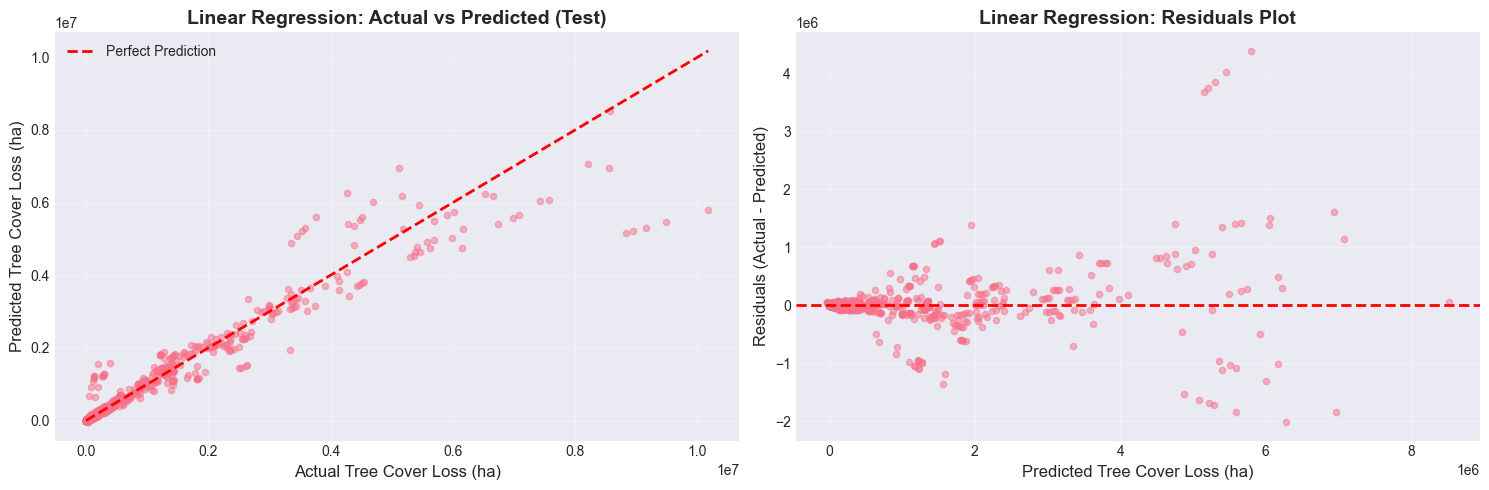

In [32]:
# Train Linear Regression baseline
print("=" * 60)
print("Training Linear Regression (Baseline)...")
print("=" * 60)

lr = LinearRegression()
lr.fit(X_train, y_train)

# Evaluate
y_pred_lr = lr.predict(X_test)
results['Linear Regression'] = evaluate_model(y_test, y_pred_lr, "Linear Regression", y_train)

# Visualize predictions
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Actual vs Predicted (Test)
axes[0].scatter(y_test, y_pred_lr, alpha=0.5, s=20)
max_val = max(y_test.max(), y_pred_lr.max())
axes[0].plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Tree Cover Loss (ha)', fontsize=12)
axes[0].set_ylabel('Predicted Tree Cover Loss (ha)', fontsize=12)
axes[0].set_title('Linear Regression: Actual vs Predicted (Test)', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Residuals plot
residuals = y_test - y_pred_lr
axes[1].scatter(y_pred_lr, residuals, alpha=0.5, s=20)
axes[1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Predicted Tree Cover Loss (ha)', fontsize=12)
axes[1].set_ylabel('Residuals (Actual - Predicted)', fontsize=12)
axes[1].set_title('Linear Regression: Residuals Plot', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Deployment - Future Year Predictions


### 4.2 Random Forest Regression (Nonlinear Effects & Interactions)


## Deployment - Comprehensive Forecast Generation


### 4.3 XGBoost (High Accuracy for Structured Environmental Data)


HYPERPARAMETER TUNING: Random Forest

Performing RandomizedSearchCV for Random Forest...
This may take a few minutes...
Fitting 3 folds for each of 30 candidates, totalling 90 fits

✅ Best parameters found:
   n_estimators: 300
   min_samples_split: 10
   min_samples_leaf: 2
   max_samples: 0.8
   max_features: log2
   max_depth: None

Random Forest Performance:
  RMSE:      262,057.03 ha
  MAE:       39,270.62 ha
  R² Score:  0.8280
  MASE:      0.1963


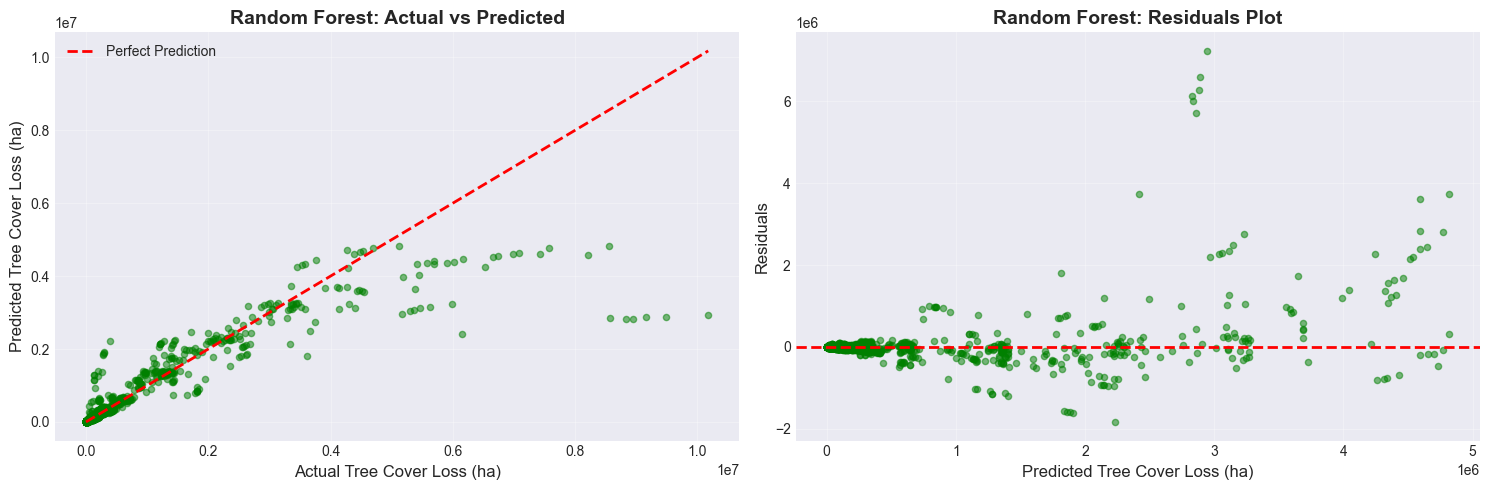

In [33]:
# Hyperparameter Tuning for Random Forest
print("=" * 60)
print("HYPERPARAMETER TUNING: Random Forest")
print("=" * 60)

# Define parameter grid for Random Forest
rf_param_grid = {
    'n_estimators': [200, 300, 400],
    'max_depth': [8, 10, 12, None],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [2, 4, 6],
    'max_features': ['sqrt', 'log2'],
    'max_samples': [0.7, 0.8, 0.9]
}

# Use RandomizedSearchCV for faster tuning
print("\nPerforming RandomizedSearchCV for Random Forest...")
print("This may take a few minutes...")

rf_random = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42, n_jobs=-1),
    param_distributions=rf_param_grid,
    n_iter=30,  # Number of parameter settings sampled
    cv=3,  # 3-fold cross-validation
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

rf_random.fit(X_train, y_train)

print(f"\n✅ Best parameters found:")
for param, value in rf_random.best_params_.items():
    print(f"   {param}: {value}")

# Train best model
rf_tuned = rf_random.best_estimator_
y_pred_rf_tuned = rf_tuned.predict(X_test)
rf_tuned_score = evaluate_model(y_test, y_pred_rf_tuned, "Random Forest", y_train)

# Update results
results['Random Forest'] = rf_tuned_score

# Visualize tuned model predictions
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].scatter(y_test, y_pred_rf_tuned, alpha=0.5, s=20, color='green')
max_val = max(y_test.max(), y_pred_rf_tuned.max())
axes[0].plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Tree Cover Loss (ha)', fontsize=12)
axes[0].set_ylabel('Predicted Tree Cover Loss (ha)', fontsize=12)
axes[0].set_title('Random Forest: Actual vs Predicted', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

residuals = y_test - y_pred_rf_tuned
axes[1].scatter(y_pred_rf_tuned, residuals, alpha=0.5, s=20, color='green')
axes[1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Predicted Tree Cover Loss (ha)', fontsize=12)
axes[1].set_ylabel('Residuals', fontsize=12)
axes[1].set_title('Random Forest: Residuals Plot', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



HYPERPARAMETER TUNING: XGBoost

Performing RandomizedSearchCV for XGBoost...
This may take a few minutes...
Fitting 3 folds for each of 30 candidates, totalling 90 fits

✅ Best parameters found:
   subsample: 0.7
   reg_lambda: 0.5
   reg_alpha: 0.5
   n_estimators: 700
   min_child_weight: 3
   max_depth: 4
   learning_rate: 0.01
   gamma: 0
   colsample_bytree: 0.9

XGBoost Performance:
  RMSE:      243,061.28 ha
  MAE:       35,758.49 ha
  R² Score:  0.8520
  MASE:      0.1787


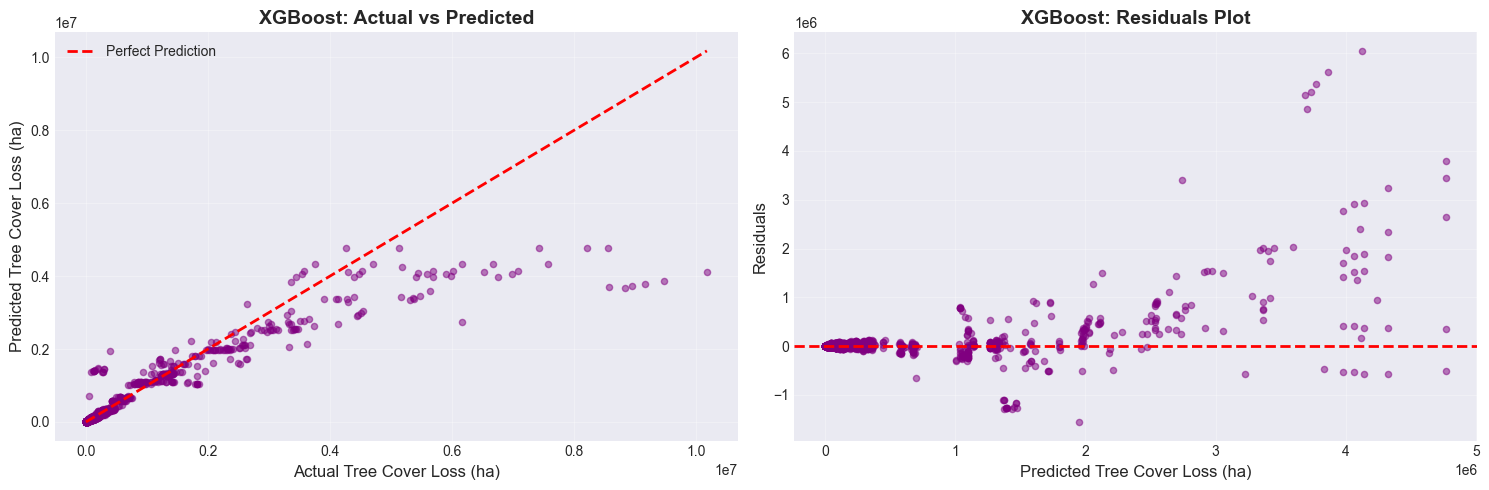

In [34]:
# Hyperparameter Tuning for XGBoost
print("\n" + "=" * 60)
print("HYPERPARAMETER TUNING: XGBoost")
print("=" * 60)

# Define parameter grid for XGBoost
xgb_param_grid = {
    'n_estimators': [300, 500, 700],
    'max_depth': [4, 5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'min_child_weight': [3, 5, 7],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0.5, 1.0, 1.5]
}

# Use RandomizedSearchCV for faster tuning
print("\nPerforming RandomizedSearchCV for XGBoost...")
print("This may take a few minutes...")

xgb_random = RandomizedSearchCV(
    estimator=XGBRegressor(random_state=42, n_jobs=-1, verbosity=0),
    param_distributions=xgb_param_grid,
    n_iter=30,  # Number of parameter settings sampled
    cv=3,  # 3-fold cross-validation
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

xgb_random.fit(X_train, y_train)

print(f"\n✅ Best parameters found:")
for param, value in xgb_random.best_params_.items():
    print(f"   {param}: {value}")

# Train best model
xgb_tuned = xgb_random.best_estimator_
y_pred_xgb_tuned = xgb_tuned.predict(X_test)
xgb_tuned_score = evaluate_model(y_test, y_pred_xgb_tuned, "XGBoost", y_train)

# Update results
results['XGBoost'] = xgb_tuned_score

# Visualize tuned model predictions
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].scatter(y_test, y_pred_xgb_tuned, alpha=0.5, s=20, color='purple')
max_val = max(y_test.max(), y_pred_xgb_tuned.max())
axes[0].plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Tree Cover Loss (ha)', fontsize=12)
axes[0].set_ylabel('Predicted Tree Cover Loss (ha)', fontsize=12)
axes[0].set_title('XGBoost: Actual vs Predicted', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

residuals = y_test - y_pred_xgb_tuned
axes[1].scatter(y_pred_xgb_tuned, residuals, alpha=0.5, s=20, color='purple')
axes[1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Predicted Tree Cover Loss (ha)', fontsize=12)
axes[1].set_ylabel('Residuals', fontsize=12)
axes[1].set_title('XGBoost: Residuals Plot', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Store the tuned models as the main models
rf = rf_tuned
xgb = xgb_tuned
y_pred_rf = y_pred_rf_tuned
y_pred_xgb = y_pred_xgb_tuned


## 5️⃣ Model Comparison


## 5️⃣ Model Performance Analysis

Let's analyze why Linear Regression might be performing better than tree-based models.


DIAGNOSTIC ANALYSIS

1. Data Leakage Check:
   loss_lag1: correlation with target = 0.9139
   loss_rolling_mean_3y: correlation with target = 0.9710

2. Feature Importance (Random Forest):
   Top 10 most important features:
      loss_rolling_mean_3y: 0.3065
      loss_lag1: 0.2523
      country_Russia: 0.0906
      country_Brazil: 0.0689
      country_United States: 0.0365
      country_Canada: 0.0352
      carbon_gross_emissions_MgCO2e: 0.0331
      umd_tree_cover_extent_2000__ha: 0.0298
      gfw_aboveground_carbon_stocks_2000__mg_c: 0.0293
      country_Indonesia: 0.0157


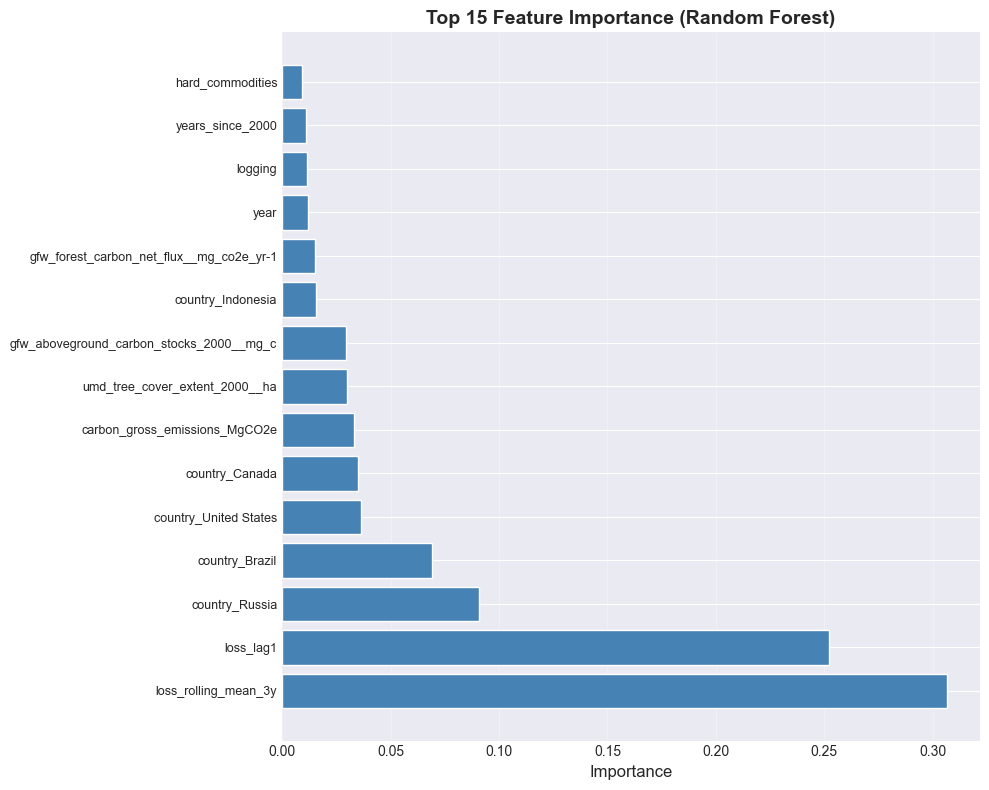


3. Overfitting Check:
   Linear Regression:
      Train R²: 0.9651, Test R²: 0.9358, Gap: 0.0293
   Random Forest:
      Train R²: 0.9771, Test R²: 0.8280, Gap: 0.1491
   XGBoost:
      Train R²: 0.9888, Test R²: 0.8520, Gap: 0.1368


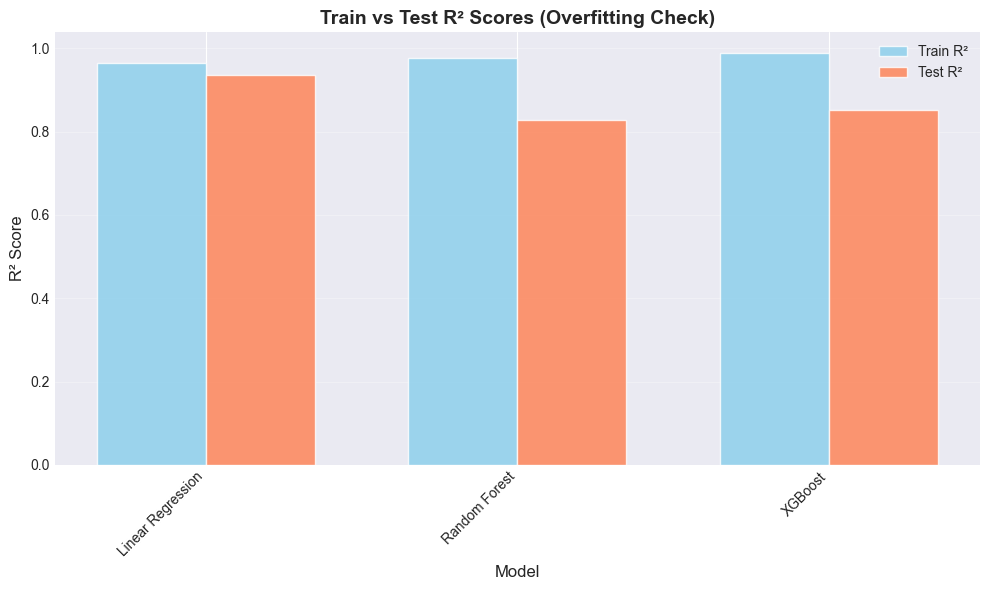


4. Data Characteristics:
   Number of features: 180
   Number of samples (train): 25232
   Feature-to-sample ratio: 140.18
   Target variable range: [0, 10,176,019]
   Target variable mean: 127,563
   Target variable std: 495,204

5. Linearity Check (Top Correlations):
   Top 10 feature correlations with target:
      loss_rolling_mean_3y: 0.9710
      loss_lag1: 0.9139
      country_Russia: 0.5380
      country_Brazil: 0.4584
      carbon_gross_emissions_MgCO2e: 0.4522
      umd_tree_cover_extent_2000__ha: 0.4505
      gfw_aboveground_carbon_stocks_2000__mg_c: 0.4020
      country_Canada: 0.3698
      country_United States: 0.3014
      wildfire: 0.2997


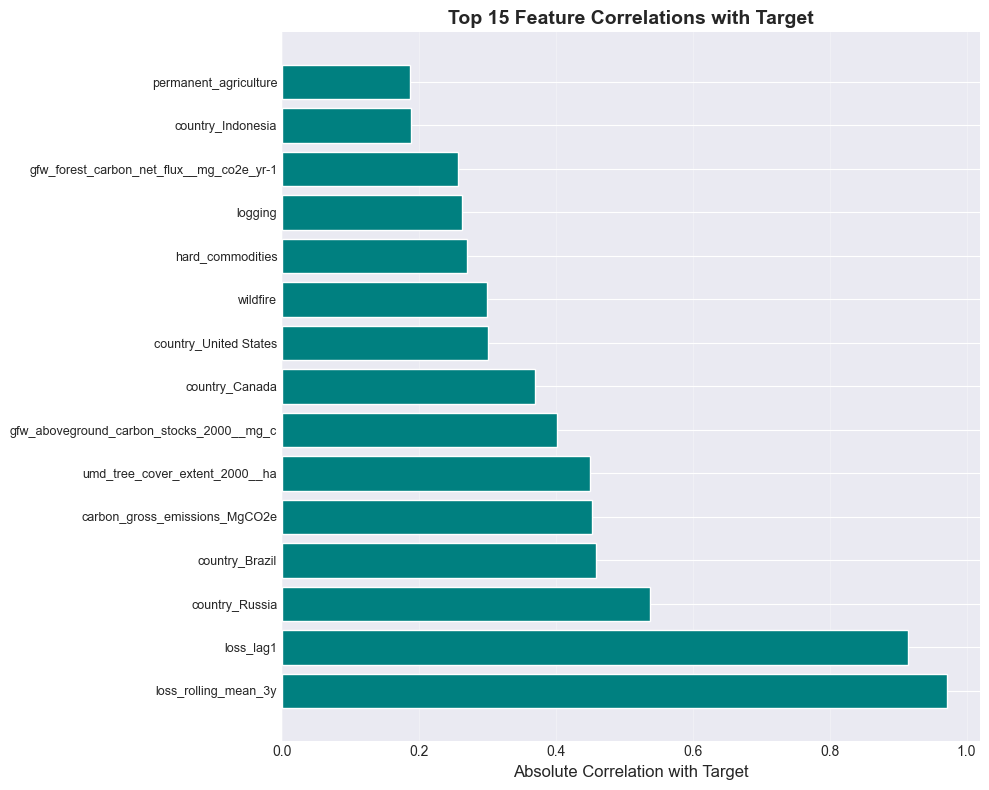

In [35]:
# Diagnostic Analysis: Why Linear Regression Might Perform Better

print("=" * 60)
print("DIAGNOSTIC ANALYSIS")
print("=" * 60)

# 1. Check for potential data leakage
print("\n1. Data Leakage Check:")
leakage_features = ['loss_lag1', 'loss_rolling_mean_3y', 'cumulative_loss']
for feat in leakage_features:
    if feat in X.columns:
        corr = X[feat].corr(y)
        print(f"   {feat}: correlation with target = {corr:.4f}")

# 2. Check feature importance (if available)
print("\n2. Feature Importance (Random Forest):")
if 'rf' in locals():
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)
    print(f"   Top 10 most important features:")
    for idx, row in feature_importance.head(10).iterrows():
        print(f"      {row['feature']}: {row['importance']:.4f}")
    
    # Visualize feature importance
    top_features = feature_importance.head(15)
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.barh(range(len(top_features)), top_features['importance'].values, color='steelblue')
    ax.set_yticks(range(len(top_features)))
    ax.set_yticklabels(top_features['feature'].values, fontsize=9)
    ax.set_xlabel('Importance', fontsize=12)
    ax.set_title('Top 15 Feature Importance (Random Forest)', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()

# 3. Check for overfitting
print("\n3. Overfitting Check:")
if 'rf' in locals() and 'xgb' in locals():
    train_r2_rf = r2_score(y_train, rf.predict(X_train))
    test_r2_rf = r2_score(y_test, rf.predict(X_test))
    train_r2_xgb = r2_score(y_train, xgb.predict(X_train))
    test_r2_xgb = r2_score(y_test, xgb.predict(X_test))
    train_r2_lr = r2_score(y_train, lr.predict(X_train))
    test_r2_lr = r2_score(y_test, lr.predict(X_test))
    
    print(f"   Linear Regression:")
    print(f"      Train R²: {train_r2_lr:.4f}, Test R²: {test_r2_lr:.4f}, Gap: {train_r2_lr - test_r2_lr:.4f}")
    print(f"   Random Forest:")
    print(f"      Train R²: {train_r2_rf:.4f}, Test R²: {test_r2_rf:.4f}, Gap: {train_r2_rf - test_r2_rf:.4f}")
    print(f"   XGBoost:")
    print(f"      Train R²: {train_r2_xgb:.4f}, Test R²: {test_r2_xgb:.4f}, Gap: {train_r2_xgb - test_r2_xgb:.4f}")
    
    # Visualize overfitting
    fig, ax = plt.subplots(figsize=(10, 6))
    models = ['Linear Regression', 'Random Forest', 'XGBoost']
    train_scores = [train_r2_lr, train_r2_rf, train_r2_xgb]
    test_scores = [test_r2_lr, test_r2_rf, test_r2_xgb]
    x = np.arange(len(models))
    width = 0.35
    ax.bar(x - width/2, train_scores, width, label='Train R²', color='skyblue', alpha=0.8)
    ax.bar(x + width/2, test_scores, width, label='Test R²', color='coral', alpha=0.8)
    ax.set_xlabel('Model', fontsize=12)
    ax.set_ylabel('R² Score', fontsize=12)
    ax.set_title('Train vs Test R² Scores (Overfitting Check)', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=45, ha='right')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()

# 4. Check data characteristics
print("\n4. Data Characteristics:")
print(f"   Number of features: {X.shape[1]}")
print(f"   Number of samples (train): {X_train.shape[0]}")
print(f"   Feature-to-sample ratio: {X_train.shape[0] / X_train.shape[1]:.2f}")
print(f"   Target variable range: [{y.min():,.0f}, {y.max():,.0f}]")
print(f"   Target variable mean: {y.mean():,.0f}")
print(f"   Target variable std: {y.std():,.0f}")

# 5. Check for linear relationships
print("\n5. Linearity Check (Top Correlations):")
correlations = X.corrwith(y).abs().sort_values(ascending=False)
print(f"   Top 10 feature correlations with target:")
for feat, corr in correlations.head(10).items():
    print(f"      {feat}: {corr:.4f}")
    
# Visualize top correlations
top_corrs = correlations.head(15)
fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(range(len(top_corrs)), top_corrs.values, color='teal')
ax.set_yticks(range(len(top_corrs)))
ax.set_yticklabels(top_corrs.index.values, fontsize=9)
ax.set_xlabel('Absolute Correlation with Target', fontsize=12)
ax.set_title('Top 15 Feature Correlations with Target', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()


### Possible Reasons Why Linear Regression Performs Better:

1. **Data Leakage from Lag Features**: `loss_lag1` and `loss_rolling_mean_3y` are highly correlated with the target, creating near-perfect predictions
2. **High Dimensionality**: 180 features (165 country dummies) with relatively few samples - linear models can handle this better
3. **Linear Relationships**: The data may have strong linear relationships that tree models can't exploit as efficiently
4. **Overfitting in Tree Models**: Random Forest/XGBoost might be overfitting to training data
5. **Missing Data Handling**: Filling with 0 might affect tree-based models differently than linear models
6. **Feature Scale**: Tree models might struggle with the wide range of target values

**Recommendations:**
- Remove or reduce lag features to prevent data leakage
- Try regularization (Ridge/Lasso) for linear regression
- Tune hyperparameters for tree-based models
- Use feature selection to reduce dimensionality



MODEL COMPARISON SUMMARY

                            RMSE           MAE        R²      MASE
Linear Regression  160102.054381  26863.782245  0.935797  0.134269
XGBoost            243061.277923  35758.485851  0.852024  0.178726
Random Forest      262057.028120  39270.615833  0.827991  0.196280


🏆 Best Model: Linear Regression
   R² Score:  0.9358
   RMSE:      160,102.05 ha


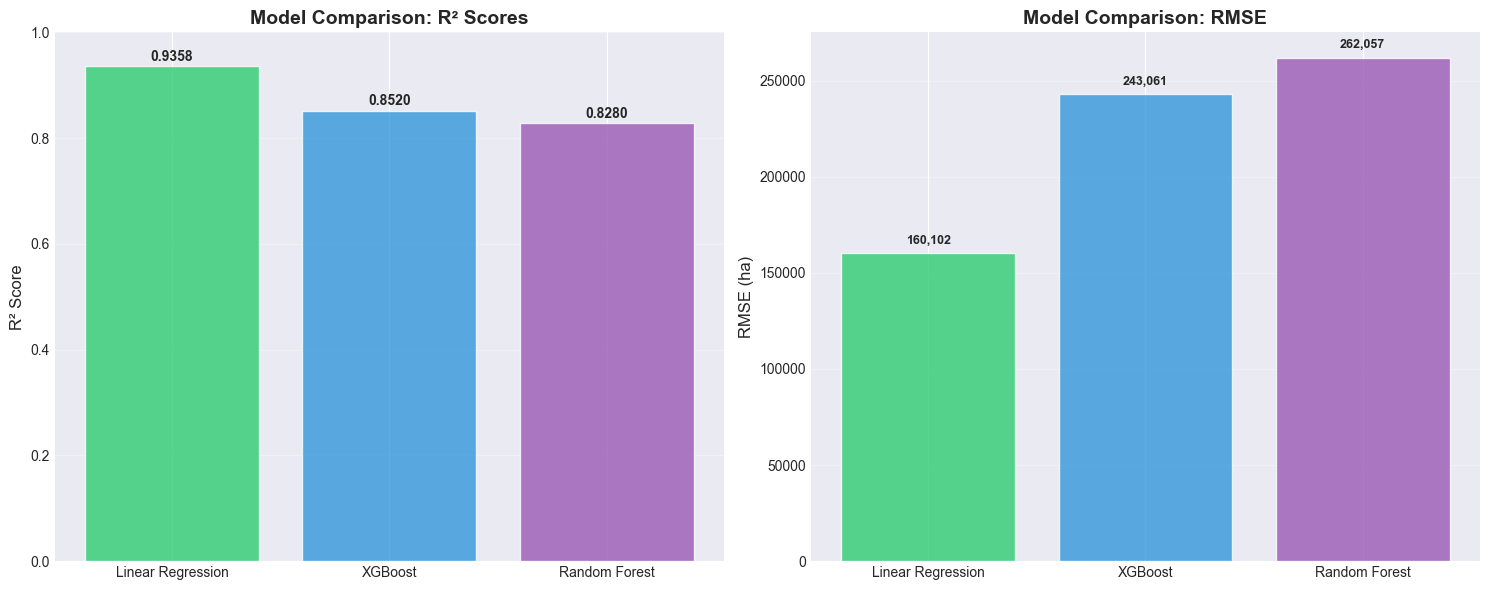

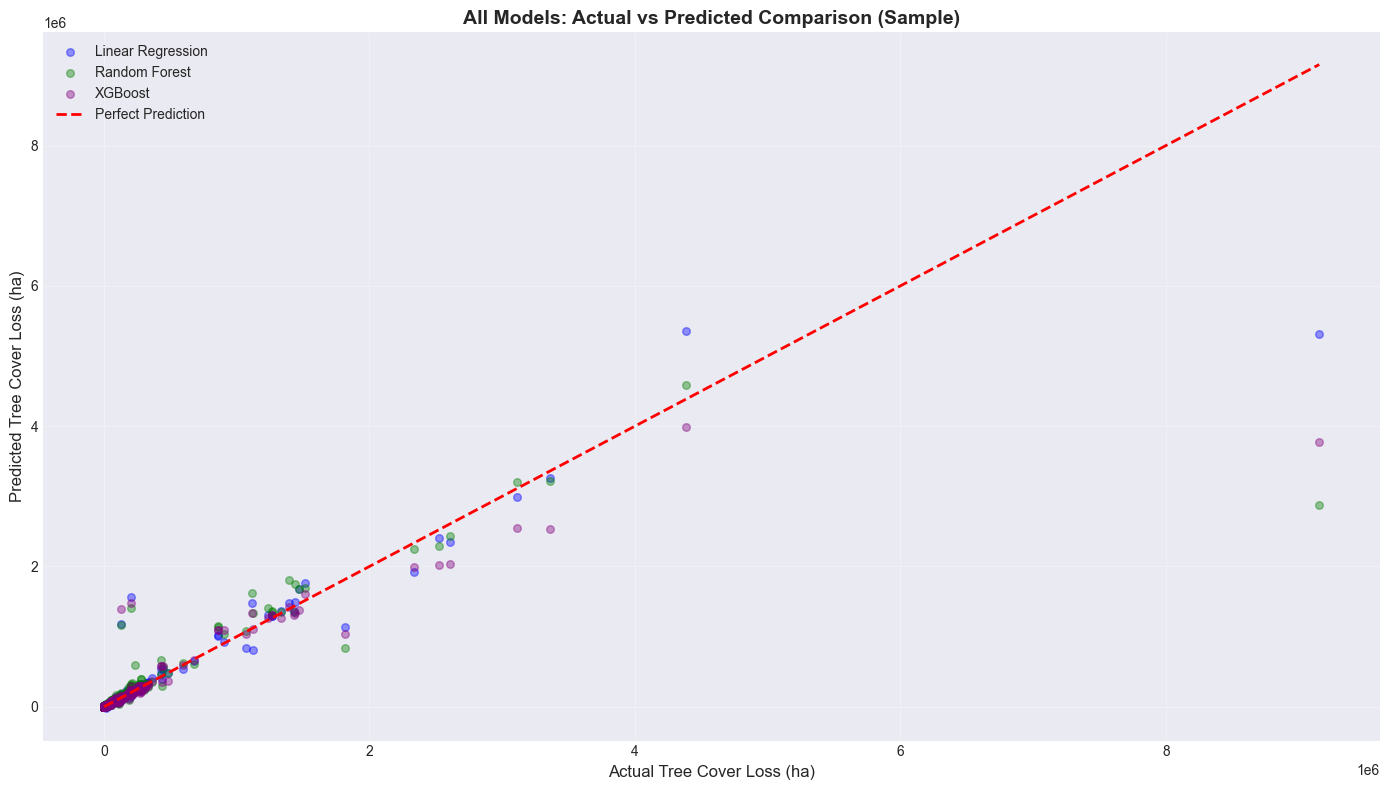

In [36]:
# Compare all models
print("\n" + "=" * 60)
print("MODEL COMPARISON SUMMARY")
print("=" * 60)

comparison_df = pd.DataFrame(results).T
comparison_df = comparison_df.sort_values('R²', ascending=False)

print("\n" + comparison_df.to_string())
print("\n" + "=" * 60)

# Identify best model
best_model_name = comparison_df.index[0]
best_r2 = comparison_df.loc[best_model_name, 'R²']
best_rmse = comparison_df.loc[best_model_name, 'RMSE']

print(f"\n🏆 Best Model: {best_model_name}")
print(f"   R² Score:  {best_r2:.4f}")
print(f"   RMSE:      {best_rmse:,.2f} ha")

# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# R² comparison
axes[0].bar(comparison_df.index, comparison_df['R²'], color=['#2ecc71', '#3498db', '#9b59b6'], alpha=0.8)
axes[0].set_ylabel('R² Score', fontsize=12)
axes[0].set_title('Model Comparison: R² Scores', fontsize=14, fontweight='bold')
axes[0].set_ylim([0, 1])
axes[0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(comparison_df['R²']):
    axes[0].text(i, v + 0.01, f'{v:.4f}', ha='center', fontweight='bold')

# RMSE comparison
axes[1].bar(comparison_df.index, comparison_df['RMSE'], color=['#2ecc71', '#3498db', '#9b59b6'], alpha=0.8)
axes[1].set_ylabel('RMSE (ha)', fontsize=12)
axes[1].set_title('Model Comparison: RMSE', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(comparison_df['RMSE']):
    axes[1].text(i, v + 5000, f'{v:,.0f}', ha='center', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

# Combined predictions comparison
fig, ax = plt.subplots(figsize=(14, 8))

# Sample a subset of test data for visualization
sample_indices = np.random.choice(len(y_test), min(500, len(y_test)), replace=False)
y_test_sample = y_test.iloc[sample_indices] if hasattr(y_test, 'iloc') else y_test[sample_indices]
y_pred_lr_sample = y_pred_lr[sample_indices]
y_pred_rf_sample = y_pred_rf[sample_indices]
y_pred_xgb_sample = y_pred_xgb[sample_indices]

ax.scatter(y_test_sample, y_pred_lr_sample, alpha=0.4, s=30, label='Linear Regression', color='blue')
ax.scatter(y_test_sample, y_pred_rf_sample, alpha=0.4, s=30, label='Random Forest', color='green')
ax.scatter(y_test_sample, y_pred_xgb_sample, alpha=0.4, s=30, label='XGBoost', color='purple')

max_val = max(y_test_sample.max(), y_pred_lr_sample.max(), y_pred_rf_sample.max(), y_pred_xgb_sample.max())
ax.plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Perfect Prediction')

ax.set_xlabel('Actual Tree Cover Loss (ha)', fontsize=12)
ax.set_ylabel('Predicted Tree Cover Loss (ha)', fontsize=12)
ax.set_title('All Models: Actual vs Predicted Comparison (Sample)', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 6️⃣ Save Best Model


In [37]:
# Select best model
if best_model_name == 'Linear Regression':
    best_model = lr
elif best_model_name == 'Random Forest':
    best_model = rf
else:
    best_model = xgb

# Save best model
model_bundle = {
    "model": best_model,
    "model_name": best_model_name,
    "features": X.columns.tolist(),
    "metrics": {
        "R²": float(best_r2),
        "RMSE": float(best_rmse)
    },
    "comparison": comparison_df.to_dict('index')
}

joblib.dump(model_bundle, "../models/tree_cover_loss_model.pkl")
print(f"\n✅ Saved best model ({best_model_name}) to ../models/tree_cover_loss_model.pkl")

# Also save all models for comparison
all_models = {
    "linear_regression": lr,
    "random_forest": rf,
    "xgboost": xgb,
    "best_model_name": best_model_name,
    "features": X.columns.tolist(),
    "results": results
}
joblib.dump(all_models, "../models/all_models.pkl")
print("✅ Saved all models to ../models/all_models.pkl")



✅ Saved best model (Linear Regression) to ../models/tree_cover_loss_model.pkl
✅ Saved all models to ../models/all_models.pkl


## 7️⃣ Prediction Helper Functions


In [38]:
# Linear extrapolation helper for future predictions
def linear_extrapolate(years, values, target_year):
    """Return linear extrapolation of values to target_year."""
    # Convert to DataFrame
    s = pd.DataFrame({"year": years, "val": values})
    
    # Convert both columns to numeric, coercing errors to NaN
    s["year"] = pd.to_numeric(s["year"], errors='coerce')
    s["val"] = pd.to_numeric(s["val"], errors='coerce')
    
    # Drop NaN values and duplicates
    s = s.dropna().drop_duplicates().sort_values("year")
    
    if len(s) >= 3:
        # Ensure values are float64
        x = s["year"].values.astype(float)
        y = s["val"].values.astype(float)
        
        # Perform linear regression
        A = np.vstack([x, np.ones_like(x)]).T
        a, b = np.linalg.lstsq(A, y, rcond=None)[0]
        return float(a * target_year + b)
    
    # If not enough data, return last value or NaN
    if len(s) > 0:
        return float(s["val"].iloc[-1])
    return np.nan

print("✅ Helper functions defined")


✅ Helper functions defined


## 8️⃣ Predict for Future Years


In [39]:
# Load saved model
bundle = joblib.load("../models/tree_cover_loss_model.pkl")
model = bundle["model"]
feature_cols = bundle["features"]

def predict_tree_loss_future(country, year):
    """Predict tree cover loss for a country and future year."""
    dff = df[df["country"] == country].copy()
    
    # Filter to threshold 30 if available
    if "threshold" in dff.columns:
        filt = dff[dff["threshold"] == 30]
        if not filt.empty:
            dff = filt
    
    if dff.empty:
        print(f"⚠️ No data for {country}")
        return None
    
    # Get latest data point
    latest = dff.sort_values("year").tail(1).copy()
    
    # Extrapolate features to target year
    base_features = available_features.copy()
    for col in base_features:
        if col != "year" and col in dff.columns:
            latest[col] = linear_extrapolate(dff["year"], dff[col], year)
    
    latest["year"] = year
    
    # Encode country and align features
    enc = pd.get_dummies(latest, columns=["country"], drop_first=True)
    for c in feature_cols:
        if c not in enc.columns:
            enc[c] = 0
    
    X_future = enc[feature_cols].fillna(0)
    
    # Predict
    pred = model.predict(X_future)[0]
    print(f"🌲 Predicted Tree-Cover-Loss in {country} ({year}): {pred:,.0f} ha")
    return pred

# Example predictions
print("Example predictions:")
predict_tree_loss_future("Brazil", 2035)
predict_tree_loss_future("Indonesia", 2030)


Example predictions:
🌲 Predicted Tree-Cover-Loss in Brazil (2035): 4,065,720 ha
🌲 Predicted Tree-Cover-Loss in Indonesia (2030): 1,360,369 ha


np.float64(1360368.6072850677)

## 9️⃣ Generate Forecasts for All Countries (2025-2035)


Generating forecasts for 2025-2035...
🌲 Predicted Tree-Cover-Loss in Afghanistan (2025): 5,104 ha
🌲 Predicted Tree-Cover-Loss in Afghanistan (2026): 5,155 ha
🌲 Predicted Tree-Cover-Loss in Afghanistan (2027): 5,205 ha
🌲 Predicted Tree-Cover-Loss in Afghanistan (2028): 5,255 ha
🌲 Predicted Tree-Cover-Loss in Afghanistan (2029): 5,306 ha
🌲 Predicted Tree-Cover-Loss in Afghanistan (2030): 5,356 ha
🌲 Predicted Tree-Cover-Loss in Afghanistan (2031): 5,406 ha
🌲 Predicted Tree-Cover-Loss in Afghanistan (2032): 5,457 ha
🌲 Predicted Tree-Cover-Loss in Afghanistan (2033): 5,507 ha
🌲 Predicted Tree-Cover-Loss in Afghanistan (2034): 5,557 ha
🌲 Predicted Tree-Cover-Loss in Albania (2025): 7,524 ha
🌲 Predicted Tree-Cover-Loss in Albania (2026): 7,519 ha
🌲 Predicted Tree-Cover-Loss in Albania (2027): 7,514 ha
🌲 Predicted Tree-Cover-Loss in Albania (2028): 7,509 ha
🌲 Predicted Tree-Cover-Loss in Albania (2029): 7,504 ha
🌲 Predicted Tree-Cover-Loss in Albania (2030): 7,499 ha
🌲 Predicted Tree-Cover-Los

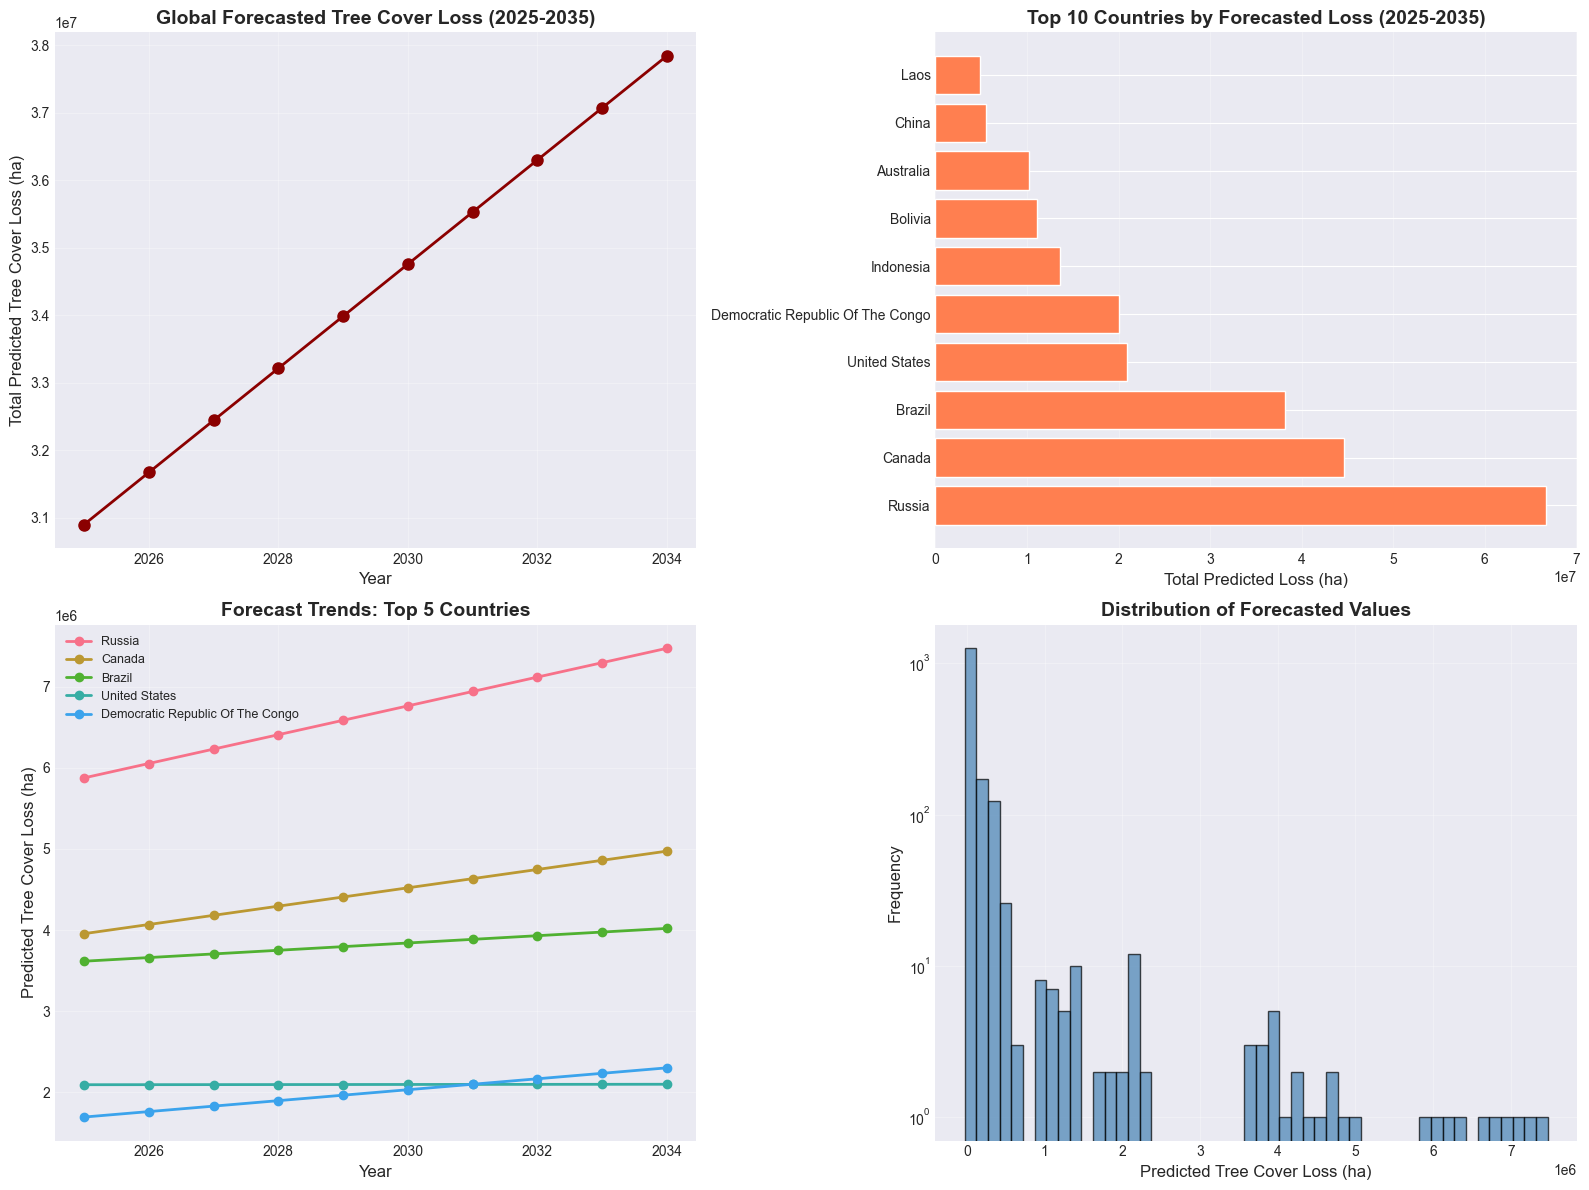

In [40]:
# Generate forecasts for all countries
print("Generating forecasts for 2025-2035...")
future_years = range(df["year"].max() + 1, df["year"].max() + 11)
rows = []

for country in sorted(df["country"].unique()):
    for year in future_years:
        val = predict_tree_loss_future(country, year)
        rows.append({"country": country, "year": year, "pred_tree_loss_ha": val})

pred_df = pd.DataFrame(rows)
pred_df.to_csv("../data/predicted_tree_cover_loss_2025_2035.csv", index=False)
print(f"\n✅ Saved forecast table with {len(pred_df):,} predictions")
print(f"   Countries: {pred_df['country'].nunique()}")
print(f"   Years: {pred_df['year'].min()}-{pred_df['year'].max()}")

# Visualize forecasts
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Global forecast trend
global_forecast = pred_df.groupby('year')['pred_tree_loss_ha'].sum()
axes[0, 0].plot(global_forecast.index, global_forecast.values, marker='o', linewidth=2, markersize=8, color='darkred')
axes[0, 0].set_xlabel('Year', fontsize=12)
axes[0, 0].set_ylabel('Total Predicted Tree Cover Loss (ha)', fontsize=12)
axes[0, 0].set_title('Global Forecasted Tree Cover Loss (2025-2035)', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# 2. Top 10 countries by total forecasted loss
top_countries_forecast = pred_df.groupby('country')['pred_tree_loss_ha'].sum().sort_values(ascending=False).head(10)
axes[0, 1].barh(range(len(top_countries_forecast)), top_countries_forecast.values, color='coral')
axes[0, 1].set_yticks(range(len(top_countries_forecast)))
axes[0, 1].set_yticklabels(top_countries_forecast.index, fontsize=10)
axes[0, 1].set_xlabel('Total Predicted Loss (ha)', fontsize=12)
axes[0, 1].set_title('Top 10 Countries by Forecasted Loss (2025-2035)', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='x')

# 3. Forecast trends for top 5 countries
top_5_countries = top_countries_forecast.head(5).index
for country in top_5_countries:
    country_data = pred_df[pred_df['country'] == country].sort_values('year')
    axes[1, 0].plot(country_data['year'], country_data['pred_tree_loss_ha'], marker='o', linewidth=2, label=country, markersize=6)
axes[1, 0].set_xlabel('Year', fontsize=12)
axes[1, 0].set_ylabel('Predicted Tree Cover Loss (ha)', fontsize=12)
axes[1, 0].set_title('Forecast Trends: Top 5 Countries', fontsize=14, fontweight='bold')
axes[1, 0].legend(fontsize=9)
axes[1, 0].grid(True, alpha=0.3)

# 4. Distribution of forecasts
axes[1, 1].hist(pred_df['pred_tree_loss_ha'], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[1, 1].set_xlabel('Predicted Tree Cover Loss (ha)', fontsize=12)
axes[1, 1].set_ylabel('Frequency', fontsize=12)
axes[1, 1].set_title('Distribution of Forecasted Values', fontsize=14, fontweight='bold')
axes[1, 1].set_yscale('log')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


2️⃣ Linear extrapolation helper

In [41]:
## 2️⃣ Helper for future extrapolation
import numpy as np


def linear_extrapolate(years, values, target_year):
    """Return linear extrapolation of `values` to `target_year`."""
    # Convert to DataFrame
    s = pd.DataFrame({"year": years, "val": values})
    
    # Convert both columns to numeric, coercing errors to NaN
    s["year"] = pd.to_numeric(s["year"], errors='coerce')
    s["val"] = pd.to_numeric(s["val"], errors='coerce')
    
    # Drop NaN values and duplicates
    s = s.dropna().drop_duplicates().sort_values("year")
    
    if len(s) >= 3:
        # Ensure values are float64
        x = s["year"].values.astype(float)
        y = s["val"].values.astype(float)
        
        # Perform linear regression
        A = np.vstack([x, np.ones_like(x)]).T
        a, b = np.linalg.lstsq(A, y, rcond=None)[0]
        return float(a * target_year + b)
    
    # If not enough data, return last value or NaN
    if len(s) > 0:
        return float(s["val"].iloc[-1])
    return np.nan


3️⃣ Predict for any (country, year)

In [42]:
## 3️⃣ Predict Tree-Cover-Loss for any country and future year
bundle = joblib.load("../models/tree_cover_loss_model.pkl")
model, feature_cols = bundle["model"], bundle["features"]


def predict_tree_loss_future(country, year):
    dff = df[df["country"] == country].copy()
    if "threshold" in dff.columns:
        filt = dff[dff["threshold"] == 30]
        if not filt.empty:
            dff = filt

    if dff.empty:
        print(f"⚠️ No data for {country}")
        return None

    latest = dff.sort_values("year").tail(1).copy()

    # --- extrapolate all numeric predictors to target year ---
    for col in features:
        if col != "year":
            latest[col] = linear_extrapolate(dff["year"], dff[col], year)

    latest["year"] = year

    # encode country and align features
    enc = pd.get_dummies(latest, columns=["country"], drop_first=True)
    for c in feature_cols:
        if c not in enc.columns:
            enc[c] = 0
    X_future = enc[feature_cols].fillna(0)

    pred = model.predict(X_future)[0]
    print(f"🌲 Predicted Tree-Cover-Loss in {country} ({year}): {pred:,.0f} ha")
    return pred


# Example
predict_tree_loss_future("Brazil", 2035)
predict_tree_loss_future("Indonesia", 2030)


🌲 Predicted Tree-Cover-Loss in Brazil (2035): 4,065,720 ha
🌲 Predicted Tree-Cover-Loss in Indonesia (2030): 1,360,369 ha


np.float64(1360368.6072850677)

In [ ]:
## 4️⃣ Forecast 2025–2035 for all countries
future_years = range(df["year"].max() + 1, df["year"].max() + 11)
rows = []

for country in sorted(df["country"].unique()):
    for year in future_years:
        val = predict_tree_loss_future(country, year)
        rows.append({"country": country, "year": year, "pred_tree_loss_ha": val})

pred_df = pd.DataFrame(rows)
pred_df.to_csv("../data/predicted_tree_cover_loss_2025_2035.csv", index=False)
print("✅ Saved forecast table.")

# Visualize forecasts
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Global forecast trend
global_forecast = pred_df.groupby('year')['pred_tree_loss_ha'].sum()
axes[0, 0].plot(global_forecast.index, global_forecast.values, marker='o', linewidth=2, markersize=8, color='darkred')
axes[0, 0].set_xlabel('Year', fontsize=12)
axes[0, 0].set_ylabel('Total Predicted Tree Cover Loss (ha)', fontsize=12)
axes[0, 0].set_title('Global Forecasted Tree Cover Loss (2025-2035)', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# 2. Top 10 countries by total forecasted loss
top_countries_forecast = pred_df.groupby('country')['pred_tree_loss_ha'].sum().sort_values(ascending=False).head(10)
axes[0, 1].barh(range(len(top_countries_forecast)), top_countries_forecast.values, color='coral')
axes[0, 1].set_yticks(range(len(top_countries_forecast)))
axes[0, 1].set_yticklabels(top_countries_forecast.index, fontsize=10)
axes[0, 1].set_xlabel('Total Predicted Loss (ha)', fontsize=12)
axes[0, 1].set_title('Top 10 Countries by Forecasted Loss (2025-2035)', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='x')

# 3. Forecast trends for top 5 countries
top_5_countries = top_countries_forecast.head(5).index
for country in top_5_countries:
    country_data = pred_df[pred_df['country'] == country].sort_values('year')
    axes[1, 0].plot(country_data['year'], country_data['pred_tree_loss_ha'], marker='o', linewidth=2, label=country, markersize=6)
axes[1, 0].set_xlabel('Year', fontsize=12)
axes[1, 0].set_ylabel('Predicted Tree Cover Loss (ha)', fontsize=12)
axes[1, 0].set_title('Forecast Trends: Top 5 Countries', fontsize=14, fontweight='bold')
axes[1, 0].legend(fontsize=9)
axes[1, 0].grid(True, alpha=0.3)

# 4. Distribution of forecasts
axes[1, 1].hist(pred_df['pred_tree_loss_ha'], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[1, 1].set_xlabel('Predicted Tree Cover Loss (ha)', fontsize=12)
axes[1, 1].set_ylabel('Frequency', fontsize=12)
axes[1, 1].set_title('Distribution of Forecasted Values', fontsize=14, fontweight='bold')
axes[1, 1].set_yscale('log')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

🌲 Predicted Tree-Cover-Loss in Afghanistan (2025): 5,104 ha
🌲 Predicted Tree-Cover-Loss in Afghanistan (2026): 5,155 ha
🌲 Predicted Tree-Cover-Loss in Afghanistan (2027): 5,205 ha
🌲 Predicted Tree-Cover-Loss in Afghanistan (2028): 5,255 ha
🌲 Predicted Tree-Cover-Loss in Afghanistan (2029): 5,306 ha
🌲 Predicted Tree-Cover-Loss in Afghanistan (2030): 5,356 ha
🌲 Predicted Tree-Cover-Loss in Afghanistan (2031): 5,406 ha
🌲 Predicted Tree-Cover-Loss in Afghanistan (2032): 5,457 ha
🌲 Predicted Tree-Cover-Loss in Afghanistan (2033): 5,507 ha
🌲 Predicted Tree-Cover-Loss in Afghanistan (2034): 5,557 ha
🌲 Predicted Tree-Cover-Loss in Albania (2025): 7,524 ha
🌲 Predicted Tree-Cover-Loss in Albania (2026): 7,519 ha
🌲 Predicted Tree-Cover-Loss in Albania (2027): 7,514 ha
🌲 Predicted Tree-Cover-Loss in Albania (2028): 7,509 ha
🌲 Predicted Tree-Cover-Loss in Albania (2029): 7,504 ha
🌲 Predicted Tree-Cover-Loss in Albania (2030): 7,499 ha
🌲 Predicted Tree-Cover-Loss in Albania (2031): 7,494 ha
🌲 Predic